In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

## Get data

In [2]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('pipeline_data/data_????-??-??.csv')[0]

# Get the two totals
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
steps_c = steps_c + [f'total_case']
steps_d = steps_d + [f'total_death']
steps_ = steps_c + steps_d

df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

last date = 2020-12-19


In [4]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,11.0,16.0,45.0,48.0,60.0,48.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,34.0,36.0,40.0,45.0,30.0,34.0,42.0,19.0,12.0,29.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,3.0,7.0,8.0,16.0,9.0,14.0,24.0,27.0,47.0,41.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,7.0,4.0,7.0,7.0,15.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,12.0,3.0,9.0,12.0,6.0,5.0,2.0,3.0,13.0,11.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Get GLM predictions

In [5]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

### Case

In [6]:
dfs_case = []
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_case.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Sun, 20 Dec 2020   Deviance:                   4.1453e+05
Time:                        19:42:37   Pearson chi2:                 7.17e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0975      0.007    281.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3448e+05
Date:                Sun, 20 Dec 2020   Deviance:                   2.5966e+05
Time:                        19:42:41   Pearson chi2:                 1.13e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5840      0.006    403.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70378.
Date:                Sun, 20 Dec 2020   Deviance:                   1.3104e+05
Time:                        19:42:44   Pearson chi2:                 2.42e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5176      0.007    373.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0478e+05
Date:                Sun, 20 Dec 2020   Deviance:                   1.9784e+05
Time:                        19:42:48   Pearson chi2:                 3.24e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8688      0.006    479.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3787e+05
Date:                Sun, 20 Dec 2020   Deviance:                   2.6094e+05
Time:                        19:42:51   Pearson chi2:                 3.52e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6190      0.004    927.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84221.
Date:                Sun, 20 Dec 2020   Deviance:                   1.5403e+05
Time:                        19:42:54   Pearson chi2:                 1.90e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4443      0.004    835.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -80211.
Date:                Sun, 20 Dec 2020   Deviance:                   1.4545e+05
Time:                        19:42:57   Pearson chi2:                 1.93e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6039      0.004    966.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96877.
Date:                Sun, 20 Dec 2020   Deviance:                   1.7713e+05
Time:                        19:43:00   Pearson chi2:                 2.18e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0121      0.003   1371.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case32   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4203e+05
Date:                Sun, 20 Dec 2020   Deviance:                   4.6454e+05
Time:                        19:43:03   Pearson chi2:                 5.89e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.8581      0.002   2529.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case36   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4919e+05
Date:                Sun, 20 Dec 2020   Deviance:                   4.7798e+05
Time:                        19:43:06   Pearson chi2:                 5.60e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.1253      0.002   2883.

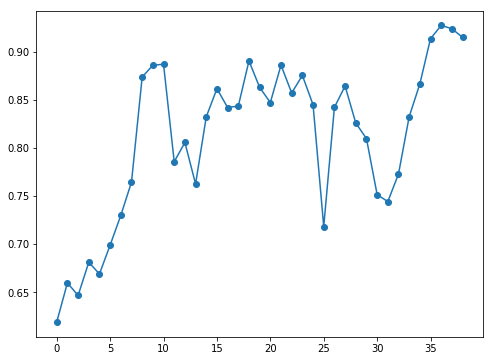

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [8]:
dfs_death = []
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_death.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10463.
Date:                Sun, 20 Dec 2020   Deviance:                       18862.
Time:                        19:44:55   Pearson chi2:                 5.66e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2600      0.049    -45.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11761.
Date:                Sun, 20 Dec 2020   Deviance:                       20793.
Time:                        19:44:59   Pearson chi2:                 3.62e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7092      0.034    -20.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6104.5
Date:                Sun, 20 Dec 2020   Deviance:                       9802.4
Time:                        19:45:02   Pearson chi2:                 2.16e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8592      0.038    -22.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6845.3
Date:                Sun, 20 Dec 2020   Deviance:                       11502.
Time:                        19:45:05   Pearson chi2:                 2.73e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0874      0.041    -26.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5131.4
Date:                Sun, 20 Dec 2020   Deviance:                       7358.2
Time:                        19:45:09   Pearson chi2:                 1.43e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7377      0.035    -21.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5231.5
Date:                Sun, 20 Dec 2020   Deviance:                       7012.4
Time:                        19:45:11   Pearson chi2:                 9.95e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4790      0.029    -16.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5142.9
Date:                Sun, 20 Dec 2020   Deviance:                       6756.2
Time:                        19:45:14   Pearson chi2:                 1.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3540      0.027    -13.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5158.3
Date:                Sun, 20 Dec 2020   Deviance:                       6744.5
Time:                        19:45:18   Pearson chi2:                 9.74e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2074      0.023     -8.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death32   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6509.2
Date:                Sun, 20 Dec 2020   Deviance:                       8181.5
Time:                        19:45:21   Pearson chi2:                 1.10e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2858      0.018     15.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death36   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10069.
Date:                Sun, 20 Dec 2020   Deviance:                       13329.
Time:                        19:45:23   Pearson chi2:                 1.62e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9907      0.013     75.

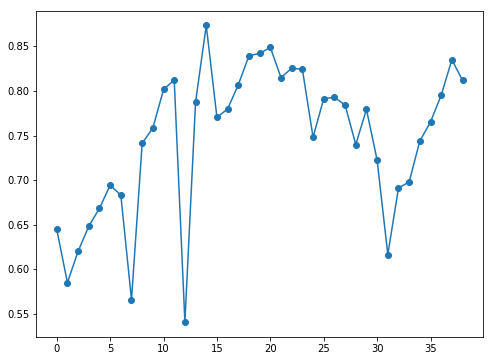

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [10]:
# cleanup and save
existing_csv = glob('pipeline_data/data_????-??-??_glm.csv')

if len(existing_csv) > 0:
    for csv in existing_csv:
        check_output(f'rm {csv}', shell=True)
        
df_z.to_csv(data_fname[:-4] + '_glm.csv', float_format='%.2f')